## Prereqs and Helper Functions

In [1]:
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore', DeprecationWarning)
%matplotlib inline

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)

import io, os, sys, types
from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell

In [2]:
def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path
    This turns "foo.bar" into "foo/bar.ipynb"
    and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
    does not exist.
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        path = ['']
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        if os.path.isfile(nb_path):
            return nb_path
        nb_path = nb_path.replace("_", " ")
        if os.path.isfile(nb_path):
            return nb_path
        
      

In [3]:
class NotebookLoader(object):
    """Module Loader for Jupyter Notebooks"""
    def __init__(self, path=None):
        self.shell = InteractiveShell.instance()
        self.path = path

    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)

        print ("importing Jupyter notebook from %s" % path)

        # load the notebook object
        with io.open(path, 'r', encoding='utf-8') as f:
            nb = read(f, 4)


        # create the module and add it to sys.modules
        # if name in sys.modules:
        #    return sys.modules[name]
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod

        # extra work to ensure that magics that would affect the user_ns
        # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__

        try:
          for cell in nb.cells:
            if cell.cell_type == 'code':
                # transform the input to executable Python
                code = self.shell.input_transformer_manager.transform_cell(cell.source)
                # run the code in themodule
                exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod

In [4]:
class NotebookFinder(object):
    """Module finder that locates Jupyter Notebooks"""
    def __init__(self):
        self.loaders = {}

    def find_module(self, fullname, path=None):
        nb_path = find_notebook(fullname, path)
        if not nb_path:
            return

        key = path
        if path:
            # lists aren't hashable
            key = os.path.sep.join(path)

        if key not in self.loaders:
            self.loaders[key] = NotebookLoader(path)
        return self.loaders[key]

In [5]:
sys.meta_path.append(NotebookFinder())

In [9]:
#Review of overall data quality
def nullcounts(ser):
    return ser.isnull().sum()

def detail_describe(frame, func=['count', nullcounts, 'mean', 'std', 'min', 'median', 'max'],
                    numeric_only=False, **kwargs):
    return frame.agg(func, **kwargs)

## Import Data Prep 

In [10]:
import lab1_final_data

## Verify Data

In [11]:
lab1_final_data.kick_imputed_scaled

,IsBadBuy,PurchDate,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel,Color,Transmission,WheelTypeID,WheelType,VehOdo,Nationality,Size,TopThreeAmericanName,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionRetailAveragePrice,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost,Mileage,Luxury,Axle,state,zip,Cylinder,model_short
0,0,1260144000,ADESA,2006,3,MAZDA,MAZDA3,i,4D SEDAN I,RED,AUTO,1,Alloy,0.759487,OTHER ASIAN,MEDIUM,OTHER,0.228291,0.297748,21973,33619,FL,0.156132,0,0.092524,HIGH,0,Unknown,FL,33619.0,Unknown,MAZDA3
1,0,1260144000,ADESA,2004,5,DODGE,1500 RAM PICKUP 2WD,ST,QUAD CAB 4.7L SLT,WHITE,AUTO,1,Alloy,0.800491,AMERICAN,LARGE TRUCK,CHRYSLER,0.191871,0.278838,19638,33619,FL,0.167129,0,0.083997,HIGH,0,2WD,FL,33619.0,Unknown,1500
2,0,1260144000,ADESA,2005,4,DODGE,STRATUS V6,SXT,4D SEDAN SXT FFV,MAROON,AUTO,2,Covers,0.622065,AMERICAN,MEDIUM,CHRYSLER,0.089637,0.177661,19638,33619,FL,0.107746,0,0.131751,HIGH,0,Unknown,FL,33619.0,V6,S
3,0,1260144000,ADESA,2004,5,DODGE,NEON,SXT,4D SEDAN,SILVER,AUTO,1,Alloy,0.548209,AMERICAN,COMPACT,CHRYSLER,0.052993,0.119191,19638,33619,FL,0.090151,0,0.023877,GOOD,0,Unknown,FL,33619.0,Unknown,NEON
4,0,1260144000,ADESA,2005,4,FORD,FOCUS,ZX3,2D COUPE ZX3,SILVER,MANUAL,2,Covers,0.582026,AMERICAN,COMPACT,FORD,0.109540,0.197620,19638,33619,FL,0.087952,0,0.079306,HIGH,0,Unknown,FL,33619.0,Unknown,S
5,0,1260144000,ADESA,2004,5,MITSUBISHI,GALANT 4C,ES,4D SEDAN ES,WHITE,AUTO,2,Covers,0.687417,OTHER ASIAN,MEDIUM,OTHER,0.109204,0.171597,19638,33619,FL,0.123142,0,0.018761,HIGH,0,Unknown,FL,33619.0,V4,L
6,0,1260144000,ADESA,2004,5,KIA,SPECTRA,EX,4D SEDAN EX,BLACK,AUTO,2,Covers,0.545603,OTHER ASIAN,MEDIUM,OTHER,0.083030,0.159672,19638,33619,FL,0.092351,0,0.010091,GOOD,0,Unknown,FL,33619.0,Unknown,S
7,0,1260144000,ADESA,2005,4,FORD,TAURUS,SE,4D SEDAN SE,WHITE,AUTO,2,Covers,0.549904,AMERICAN,MEDIUM,FORD,0.092744,0.170599,19638,33619,FL,0.098949,0,0.051592,HIGH,0,Unknown,FL,33619.0,Unknown,S
8,0,1260144000,ADESA,2007,2,KIA,SPECTRA,EX,4D SEDAN EX,BLACK,AUTO,2,Covers,0.406666,OTHER ASIAN,MEDIUM,OTHER,0.173451,0.247876,21973,33619,FL,0.123142,0,0.002843,HIGH,0,Unknown,FL,33619.0,Unknown,S
9,0,1260144000,ADESA,2007,2,FORD,FIVE HUNDRED,SEL,4D SEDAN SEL,RED,AUTO,1,Alloy,0.721846,AMERICAN,LARGE,FORD,0.219613,0.300256,21973,33619,FL,0.169328,0,0.166430,HIGH,0,Unknown,FL,33619.0,Unknown,FIVE HUNDRED


In [12]:
detail_describe(lab1_final_data.kick_imputed_scaled).transpose()

,count,nullcounts,mean,std,min,median,max
IsBadBuy,72983,0,0.122988,0.328425,0,0,1
PurchDate,72983,0,1.26309e+09,1.8196e+07,1.23111e+09,1.26403e+09,1.29367e+09
Auction,72983,0,NaN,NaN,ADESA,NaN,OTHER
VehYear,72983,0,2005.34,1.73125,2001,2005,2010
VehicleAge,72983,0,4.17664,1.71221,0,4,9
Make,72983,0,NaN,NaN,ACURA,NaN,VOLVO
Model,72983,0,NaN,NaN,1500 RAM PICKUP 2WD,NaN,ZEPHYR 3.0L V6 SFI
Trim,72983,0,NaN,NaN,1,NaN,s
SubModel,72983,0,NaN,NaN,2D CONVERTIBLE,NaN,WAGON SXT AWD
Color,72983,0,NaN,NaN,BEIGE,NaN,YELLOW


In [23]:
try:
    del lab1_final_data.kick_imputed_scaled['state']
except:
    print("Columns not found. Drop has already been performed.")

try:
    del lab1_final_data.kick_imputed_scaled['zip']
except:
    print("Columns not found. Drop has already been performed.")
    
try:
    del lab1_final_data.kick_imputed_scaled['SubModel']
except:
    print("Columns not found. Drop has already been performed.")

#should be categorical - Add Luxury, Axle, and Mileage
categorical_features = ['Auction', 'Make', 'model_short', 'Trim',
                        'Color', 'Transmission',
                       'WheelType', 'Nationality', 'Size',
                       'TopThreeAmericanName',
                        'VNST', 'Luxury', 'Axle', 'Mileage', 'Cylinder'
                       ]

Columns not found. Drop has already been performed.
Columns not found. Drop has already been performed.
Columns not found. Drop has already been performed.


## h20 Modeling

In [26]:
import pandas as pd
import numpy as np
import h2o
try:
    #clean slate, in case cluster was already running
    h2o.connect()
    h2o.shutdown(prompt=False)
    h2o.remove_all()
except:
    print("couldnt connect, no h2o found which is fine")

h2o.init(max_mem_size = "12G")  #specify max number of bytes. uses all cores by default.


Connecting to H2O server at http://localhost:54321 ....... failed.
couldnt connect, no h2o found which is fine
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "11.0.3" 2019-04-16 LTS; Java(TM) SE Runtime Environment 18.9 (build 11.0.3+12-LTS); Java HotSpot(TM) 64-Bit Server VM 18.9 (build 11.0.3+12-LTS, mixed mode)
  Starting server from /Users/Dhyan/anaconda3/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/my/7mw9x8k16nzfmqn0l_vs0bl00000gn/T/tmpa1xbu025
  JVM stdout: /var/folders/my/7mw9x8k16nzfmqn0l_vs0bl00000gn/T/tmpa1xbu025/h2o_Dhyan_started_from_python.out
  JVM stderr: /var/folders/my/7mw9x8k16nzfmqn0l_vs0bl00000gn/T/tmpa1xbu025/h2o_Dhyan_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,America/Chicago
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.6
H2O cluster version age:,25 days
H2O cluster name:,H2O_from_python_Dhyan_09mwni
H2O cluster total nodes:,1
H2O cluster free memory:,12 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


In [27]:
h2o_frame = h2o.H2OFrame(lab1_final_data.kick_imputed_scaled)

#Set variables and columns
y = 'MMRAcquisitionAuctionAveragePrice'
x = h2o_frame.col_names
try:
    x.remove('state') #duplicate column
except:
    print("Columns not found. Drop has already been performed.")

try:
    x.remove('zip') #duplicate column
except:
    print("Columns not found. Drop has already been performed.")
    
try:
    x.remove('SubModel')
except:
    print("Columns not found. Drop has already been performed.")

x.remove(y)
x.remove('PurchDate')
x.remove('VehYear')
x.remove('VNZIP1')
x.remove('WheelTypeID')
x.remove('Nationality')
x.remove('TopThreeAmericanName') 
x.remove('Trim')

print(" ")
print("Response = " + str(y))
print(" ")
print("Predictors = " + str(x))

Parse progress: |█████████████████████████████████████████████████████████| 100%
Columns not found. Drop has already been performed.
Columns not found. Drop has already been performed.
Columns not found. Drop has already been performed.
 
Response = MMRAcquisitionAuctionAveragePrice
 
Predictors = ['IsBadBuy', 'Auction', 'VehicleAge', 'Make', 'Model', 'Color', 'Transmission', 'WheelType', 'VehOdo', 'Size', 'MMRAcquisitionRetailAveragePrice', 'BYRNO', 'VNST', 'VehBCost', 'IsOnlineSale', 'WarrantyCost', 'Mileage', 'Luxury', 'Axle', 'Cylinder', 'model_short']


In [28]:
train,test,valid = h2o_frame.split_frame(ratios=[.7, .15])
train[y] = train[y].asnumeric()
test[y] = test[y].asnumeric()
valid[y] = valid[y].asnumeric()

train[continuous_features] = train[continuous_features].scale(center=True, scale=True)

In [29]:
from h2o.automl import H2OAutoML

# Run AutoML for 3 base models (limited to 1 hour max runtime by default)
aml_MMRA_A_A_Price = H2OAutoML(max_models=3, seed=1000000, nfolds = 10, include_algos = ["DRF"], stopping_metric = "RMSE")
aml_MMRA_A_A_Price.train(x=x, y=y, training_frame=train, validation_frame = valid)

# View the AutoML Leaderboard
lb = aml_MMRA_A_A_Price.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,mean_residual_deviance,rmse,mse,mae,rmsle
XRT_1_AutoML_20191027_121835,0.0257382,0.160431,0.0257382,0.0932896,nan
DRF_1_AutoML_20191027_121835,0.027254,0.165088,0.027254,0.0959496,nan


In [30]:
aml_MMRA_A_A_Price.leader

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  XRT_1_AutoML_20191027_121835


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,21766795.0,20.0,20.0,20.0,18532.0,22823.0,20920.28




ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.026846105003658936
RMSE: 0.16384781049394262
MAE: 0.09572539403863606
RMSLE: NaN
Mean Residual Deviance: 0.026846105003658936

ModelMetricsRegression: drf
** Reported on validation data. **

MSE: 0.11257222808693765
RMSE: 0.33551785062338735
MAE: 0.2929766537204741
RMSLE: 0.2856989389193692
Mean Residual Deviance: 0.11257222808693765

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 0.02573824133755343
RMSE: 0.16043142253795992
MAE: 0.09328964979966035
RMSLE: NaN
Mean Residual Deviance: 0.02573824133755343

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid,cv_6_valid,cv_7_valid,cv_8_valid,cv_9_valid,cv_10_valid
0,mae,0.09328968,0.0015709575,0.09163471,0.09276523,0.0944795,0.09156362,0.092847586,0.093819104,0.095597215,0.09390813,0.09521148,0.09107023
1,mean_residual_deviance,0.025738262,0.0020366968,0.024699636,0.025585048,0.026003499,0.023443043,0.025365027,0.028883835,0.029621612,0.024255687,0.02567816,0.02384707
2,mse,0.025738262,0.0020366968,0.024699636,0.025585048,0.026003499,0.023443043,0.025365027,0.028883835,0.029621612,0.024255687,0.02567816,0.02384707
3,r2,0.97428286,0.0015379359,0.97562313,0.9746508,0.97406393,0.97542566,0.9748042,0.97242206,0.97084576,0.97507787,0.97428256,0.97563255
4,residual_deviance,0.025738262,0.0020366968,0.024699636,0.025585048,0.026003499,0.023443043,0.025365027,0.028883835,0.029621612,0.024255687,0.02567816,0.02384707
5,rmse,0.16032188,0.006249926,0.15716118,0.15995327,0.161256,0.1531112,0.15926401,0.16995245,0.1721093,0.15574238,0.16024406,0.15442497
6,rmsle,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
0,,2019-10-27 12:29:32,5 min 17.329 sec,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,,2019-10-27 12:29:37,5 min 21.717 sec,5.0,0.241877,0.129928,0.058504,0.357358,0.303851,0.127704
2,,2019-10-27 12:29:40,5 min 25.086 sec,10.0,0.201889,0.114075,0.040759,0.338781,0.284310,0.114772
3,,2019-10-27 12:29:43,5 min 28.219 sec,15.0,0.187126,0.108267,0.035016,0.347756,0.300103,0.120934
4,,2019-10-27 12:29:46,5 min 31.342 sec,20.0,0.178464,0.104776,0.031850,0.335917,0.290968,0.112840
5,,2019-10-27 12:29:49,5 min 34.611 sec,25.0,0.172566,0.101740,0.029779,0.334628,0.291244,0.111976
6,,2019-10-27 12:29:52,5 min 37.664 sec,30.0,0.169348,0.099538,0.028679,0.337071,0.293367,0.113617
7,,2019-10-27 12:29:56,5 min 40.944 sec,35.0,0.167632,0.098202,0.028100,0.334320,0.290643,0.111770
8,,2019-10-27 12:29:59,5 min 44.175 sec,40.0,0.166095,0.097023,0.027587,0.334825,0.291619,0.112107
9,,2019-10-27 12:30:02,5 min 47.632 sec,45.0,0.165135,0.096718,0.027270,0.334887,0.292323,0.112150



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,MMRAcquisitionRetailAveragePrice,940738.562500,1.000000,0.493259
1,VehBCost,384869.687500,0.409114,0.201799
2,VehicleAge,209262.640625,0.222445,0.109723
3,Size,95656.687500,0.101683,0.050156
4,Mileage,91850.812500,0.097637,0.048160
5,Model,66474.414062,0.070662,0.034855
6,Make,32834.347656,0.034903,0.017216
7,Axle,20038.070312,0.021300,0.010507
8,Cylinder,15068.804688,0.016018,0.007901
9,VNST,12645.450195,0.013442,0.006630



See the whole table with table.as_data_frame()


In [31]:
preds = aml_MMRA_A_A_Price.leader.predict(test)

drf prediction progress: |████████████████████████████████████████████████| 100%


# DRF - Task2- Regression (Best of AutoML): MMRAcquisitionAuctionAveragePrice (h2o)

In [34]:
h2o_frame = h2o.H2OFrame(lab1_final_data.kick_imputed_scaled)

#Set variables and columns
y = 'MMRAcquisitionAuctionAveragePrice'
x = h2o_frame.col_names
try:
    x.remove('state') #duplicate column
except:
    print("Columns not found. Drop has already been performed.")

try:
    x.remove('zip') #duplicate column
except:
    print("Columns not found. Drop has already been performed.")
    
try:
    x.remove('SubModel')
except:
    print("Columns not found. Drop has already been performed.")

x.remove(y)
x.remove('PurchDate')
x.remove('VehYear')
x.remove('VNZIP1')
x.remove('WheelTypeID')
x.remove('Nationality')
x.remove('TopThreeAmericanName') 
x.remove('Trim')

print(" ")
print("Response = " + str(y))
print(" ")
print("Predictors = " + str(x))

Parse progress: |█████████████████████████████████████████████████████████| 100%
Columns not found. Drop has already been performed.
Columns not found. Drop has already been performed.
Columns not found. Drop has already been performed.
 
Response = MMRAcquisitionAuctionAveragePrice
 
Predictors = ['IsBadBuy', 'Auction', 'VehicleAge', 'Make', 'Model', 'Color', 'Transmission', 'WheelType', 'VehOdo', 'Size', 'MMRAcquisitionRetailAveragePrice', 'BYRNO', 'VNST', 'VehBCost', 'IsOnlineSale', 'WarrantyCost', 'Mileage', 'Luxury', 'Axle', 'Cylinder', 'model_short']


In [36]:
train,test,valid = h2o_frame.split_frame(ratios=[.7, .15])
train[y] = train[y].asnumeric()
test[y] = test[y].asnumeric()
valid[y] = valid[y].asnumeric()

train[continuous_features] = train[continuous_features].scale(center=True, scale=True)

In [37]:
print(y)

MMRAcquisitionAuctionAveragePrice


In [38]:
from h2o.estimators.random_forest import H2ORandomForestEstimator
# ### Distributed Random Forest #Task2
folds = 10
drf_MMRA_A_A_Price_Final = H2ORandomForestEstimator(
    model_id="drf_MMRA_A_A_Price_Final",
    ntrees=50,
    max_depth=20,
    stopping_rounds=5,
    stopping_tolerance=0.01,
    score_each_iteration=True,
    seed=3000000,
    nfolds = folds,
    keep_cross_validation_predictions = True,
    binomial_double_trees = True,
    stopping_metric = "RMSE",
    balance_classes = True)


drf_MMRA_A_A_Price_Final.train(x=x, y=y, training_frame=train, validation_frame = valid)






drf Model Build progress: |███████████████████████████████████████████████| 100%


In [39]:
# retrieve the model performance
perf = drf_MMRA_A_A_Price_Final.model_performance(valid)
perf


ModelMetricsRegression: drf
** Reported on test data. **

MSE: 0.11758712046760021
RMSE: 0.3429097847358693
MAE: 0.29801325477263746
RMSLE: 0.2915958225237462
Mean Residual Deviance: 0.11758712046760021


In [48]:
drf_MMRA_A_A_Price_Final.model_performance(xval = True)


ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 0.0282984304313963
RMSE: 0.16822137328947323
MAE: 0.09736480656323976
RMSLE: NaN
Mean Residual Deviance: 0.0282984304313963


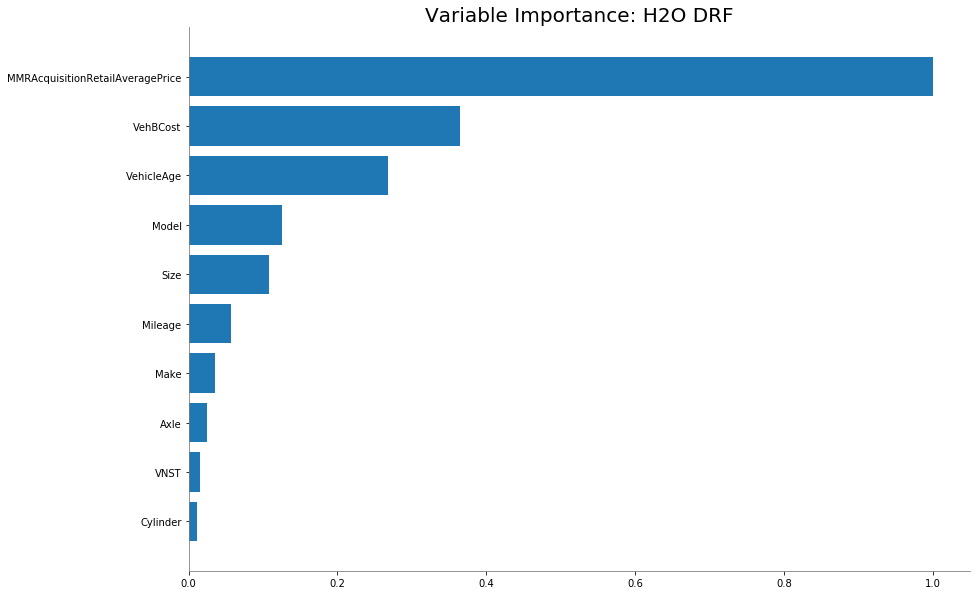

In [50]:
drf_MMRA_A_A_Price_Final.varimp_plot()

In [51]:
drf_MMRA_A_A_Price_Final

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  drf_MMRA_A_A_Price_Final


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,22.0,22.0,9517752.0,20.0,20.0,20.0,19222.0,23243.0,21075.092




ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.03167895819395779
RMSE: 0.17798583706002505
MAE: 0.10403058484855394
RMSLE: NaN
Mean Residual Deviance: 0.03167895819395779

ModelMetricsRegression: drf
** Reported on validation data. **

MSE: 0.11758712046760021
RMSE: 0.3429097847358693
MAE: 0.29801325477263746
RMSLE: 0.2915958225237462
Mean Residual Deviance: 0.11758712046760021

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 0.0282984304313963
RMSE: 0.16822137328947323
MAE: 0.09736480656323976
RMSLE: NaN
Mean Residual Deviance: 0.0282984304313963

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid,cv_6_valid,cv_7_valid,cv_8_valid,cv_9_valid,cv_10_valid
0,mae,0.097371094,0.0021445174,0.09487803,0.097697616,0.100921184,0.09600016,0.098482065,0.09696273,0.09419199,0.09920104,0.09935068,0.096025445
1,mean_residual_deviance,0.028301818,0.0024500145,0.026454499,0.026841028,0.030078894,0.027143013,0.026010338,0.028697392,0.025222642,0.028539939,0.031163221,0.032867208
2,mse,0.028301818,0.0024500145,0.026454499,0.026841028,0.030078894,0.027143013,0.026010338,0.028697392,0.025222642,0.028539939,0.031163221,0.032867208
3,r2,0.9717024,0.002117586,0.9731768,0.9726457,0.97082466,0.97217983,0.97332835,0.97108066,0.97529346,0.9714549,0.96868104,0.9683588
4,residual_deviance,0.028301818,0.0024500145,0.026454499,0.026841028,0.030078894,0.027143013,0.026010338,0.028697392,0.025222642,0.028539939,0.031163221,0.032867208
5,rmse,0.16809233,0.0072100363,0.1626484,0.16383232,0.17343268,0.16475137,0.1612772,0.16940305,0.15881638,0.16893768,0.17653108,0.18129316
6,rmsle,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
0,,2019-10-27 14:11:41,2 min 56.477 sec,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,,2019-10-27 14:11:41,2 min 57.265 sec,1.0,0.273053,0.147791,0.074558,0.426906,0.367976,0.182248
2,,2019-10-27 14:11:42,2 min 58.041 sec,2.0,0.265980,0.142400,0.070745,0.360739,0.306031,0.130132
3,,2019-10-27 14:11:43,2 min 58.709 sec,3.0,0.259306,0.139109,0.067239,0.363447,0.310719,0.132094
4,,2019-10-27 14:11:43,2 min 59.407 sec,4.0,0.246536,0.135156,0.060780,0.364049,0.310830,0.132532
5,,2019-10-27 14:11:44,3 min 0.250 sec,5.0,0.240985,0.132622,0.058074,0.346326,0.289818,0.119942
6,,2019-10-27 14:11:45,3 min 1.050 sec,6.0,0.231332,0.128425,0.053515,0.346633,0.290808,0.120155
7,,2019-10-27 14:11:46,3 min 1.808 sec,7.0,0.223917,0.125317,0.050139,0.351966,0.301363,0.123880
8,,2019-10-27 14:11:47,3 min 2.545 sec,8.0,0.215713,0.122427,0.046532,0.344621,0.290128,0.118763
9,,2019-10-27 14:11:47,3 min 3.256 sec,9.0,0.209419,0.119620,0.043856,0.347395,0.295176,0.120684



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,MMRAcquisitionRetailAveragePrice,402989.312500,1.000000,0.489006
1,VehBCost,146816.812500,0.364319,0.178154
2,VehicleAge,108113.226562,0.268278,0.131190
3,Model,50520.000000,0.125363,0.061303
4,Size,43305.894531,0.107462,0.052549
5,Mileage,22772.785156,0.056510,0.027634
6,Make,14446.900391,0.035849,0.017531
7,Axle,10018.476562,0.024860,0.012157
8,VNST,6071.148926,0.015065,0.007367
9,Cylinder,4577.852051,0.011360,0.005555



See the whole table with table.as_data_frame()


In [52]:
## Final Prediction for Model 2
final_drf_predictions = drf_MMRA_A_A_Price_Final.predict(test)

drf prediction progress: |████████████████████████████████████████████████| 100%


In [53]:
final_drf_predictions.head()

predict
0.281984
-0.195952
-0.289382
-0.11376
-0.20504
-0.102207
-0.16848
0.238103
0.00969346
-0.071046


In [54]:
drf_MMRA_A_A_Price_Final.model_performance()


ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.03167895819395779
RMSE: 0.17798583706002505
MAE: 0.10403058484855394
RMSLE: NaN
Mean Residual Deviance: 0.03167895819395779


In [55]:
drf_MMRA_A_A_Price_Final.r2()

0.9683204736576184

In [56]:
drf_MMRA_A_A_Price_Final.rmsle()

'NaN'